[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Sqlite

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [3]:
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than eight messages, then we summarize the conversation
    if len(messages) > 8:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

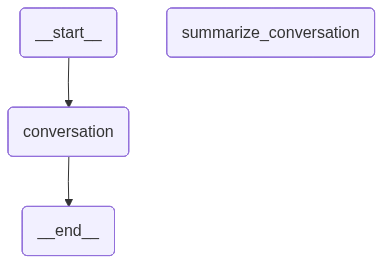

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="my name is walter white")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what show am i a character from?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i am a retired chemistry professor who synthesizes drugs in this show")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

#note: i ran the previous default questions beforehand, which got appended to the database, hence they're used as context in this output

================================== Ai Message ==================================

Got it, Walter White! If you'd like to continue talking about the 49ers or if there's anything else on your mind, feel free to let me know.
================================== Ai Message ==================================

You are a character from the television show "Breaking Bad." Walter White is a high school chemistry teacher turned methamphetamine manufacturer, portrayed by Bryan Cranston. It's a critically acclaimed series known for its intense storytelling and complex characters. Are you a fan of the show, or is there something specific you'd like to discuss about it?
================================== Ai Message ==================================

Yes, that's correct! In "Breaking Bad," Walter White is a retired chemistry professor who turns to synthesizing methamphetamine after being diagnosed with terminal lung cancer. He partners with a former student, Jesse Pinkman, to secure his family's finan

### note: in the above, i ran the previous default questions beforehand and restarted my notebook, which got appended to the database, hence they're used as context in this output as expected

In [8]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='what show am i a character from?', additional_kwargs={}, response_metadata={}, id='5d9e79d7-3904-492d-99c8-45b3e12e10aa'), AIMessage(content='You are a character from the television show "Breaking Bad." Walter White is a high school chemistry teacher turned methamphetamine manufacturer, portrayed by Bryan Cranston. It\'s a critically acclaimed series known for its intense storytelling and complex characters. Are you a fan of the show, or is there something specific you\'d like to discuss about it?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 388, 'total_tokens': 453, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CT

In [13]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="my name is walter white")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what show am i a character from?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i am a retired chemistry professor who synthesizes drugs in this show")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

Nice to meet you, Walter White! Whether you're channeling the iconic character from "Breaking Bad" or just having some fun, feel free to let me know if there's anything specific you'd like to discuss or explore.
================================== Ai Message ==================================

You are a character from the television show "Breaking Bad." Walter White is a high school chemistry teacher who turns to manufacturing and selling methamphetamine after being diagnosed with terminal lung cancer, in order to secure his family's financial future.
================================== Ai Message ==================================

That's right! In "Breaking Bad," Walter White starts as a high school chemistry teacher, but as the series progresses, he becomes deeply involved in the drug trade, using his chemistry expertise to synthesize high-quality methamphetamine. His transformation from a mild-mannered 

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [14]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='my name is walter white', additional_kwargs={}, response_metadata={}, id='49bcbb82-f49e-4ca0-a542-607120908c75'), AIMessage(content='Nice to meet you, Walter White! Whether you\'re channeling the iconic character from "Breaking Bad" or just having some fun, feel free to let me know if there\'s anything specific you\'d like to discuss or explore.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 560, 'total_tokens': 603, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTspDsvdmvHVUnM6qqKFyhRbDNeB9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bc2fdd2f-cdf1-46d6-a463-3c47fa0002b8-0', usag

In [15]:
input_message = HumanMessage(content="who is the sidekick character who cooks meth with him in the show?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

The sidekick character who cooks meth with Walter White in "Breaking Bad" is Jesse Pinkman. Jesse is a former student of Walter's and becomes his partner in the meth business. Throughout the series, their relationship is complex and evolves as they face various challenges and moral dilemmas.


In [16]:
input_message = HumanMessage(content="why did he resort to dealing drugs in the first place")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Walter White resorted to dealing drugs primarily because he was diagnosed with terminal lung cancer and wanted to ensure his family's financial security after his death. Faced with the prospect of leaving his family in financial ruin, he decided to use his chemistry skills to produce and sell methamphetamine, believing it was a quick way to make a substantial amount of money. His initial motivation was to provide for his wife, Skyler, and their children, but as the series progresses, his motivations become more complex.


In [17]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='why did he resort to dealing drugs in the first place', additional_kwargs={}, response_metadata={}, id='63a263a5-01b4-4467-bf1f-b23ef803a2ac'), AIMessage(content="Walter White resorted to dealing drugs primarily because he was diagnosed with terminal lung cancer and wanted to ensure his family's financial security after his death. Faced with the prospect of leaving his family in financial ruin, he decided to use his chemistry skills to produce and sell methamphetamine, believing it was a quick way to make a substantial amount of money. His initial motivation was to provide for his wife, Skyler, and their children, but as the series progresses, his motivations become more complex.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 478, 'total_tokens': 576, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'reject